#### https://github.com/vivva/DLinear
#### https://github.com/cure-lab/LTSF-Linear
##### https://github.com/bnsreenu/python_for_microscopists/blob/master/166b-Intro_to_time_series_Forecasting_using_LSTM_and_TimeseriesGenerator.py

In [1]:
# from DLinear import Model
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import time

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler


In [2]:
class UniVariableDataset(Dataset):
    def __init__(self, raw_data, q):
        self.data = raw_data
        self.seq_len = q

    def __len__(self):
        return self.data.shape[0] - self.seq_len -1

    def __getitem__(self, idx):
        features = self.data[idx:(idx + self.seq_len)]
        labels = self.data[idx + self.seq_len]  # the return value is numpy float
        # labels = self.data[idx + self.seq_len]  # the return value is numpy float
        features = torch.tensor(features, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)
        # features = features.unsqueeze(1)
        labels = labels.unsqueeze(0)
        # labels = labels.unsqueeze(0)
        
        return features, labels


In [3]:
# load the dataset
dataframe = pd.read_csv('archive/AirPassengers.csv', usecols=[1])
# plt.plot(dataframe)
#Convert pandas dataframe to numpy array
raw_data = dataframe.values
raw_data = raw_data.astype('float32') #COnvert values to float

# Normalization is optional but recommended for neural network as certain 
# activation functions are sensitive to magnitude of numbers. 
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(raw_data)
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
valid_size = len(dataset) - train_size

train_dataset = UniVariableDataset(dataset[0:train_size,:], 4)
                             
valid_dataset = UniVariableDataset(dataset[train_size:len(dataset),:], 4)


In [4]:
# Create data loader
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False)
# Get one batch of data
dataiter = iter(dataloader)
inputs, labels = next(dataiter)
print(inputs.shape)
print(labels.shape)


torch.Size([4, 4, 1])
torch.Size([4, 1, 1])


In [5]:
class Configs:
    def __init__(self):
        self.seq_len = 4
        self.pred_len = 1
        self.individual = False # multiplevariable or univariable
        self.enc_in = 1          # variable numbers (univariable then 1)
        self.learning_rate = 0.001
        
configs = Configs()
print(configs.seq_len)

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinearModel(nn.Module):
    """
    DLinear
    """
    def __init__(self, configs):
        super(DLinearModel, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 5
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            self.Linear_Decoder = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Decoder.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Decoder = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]


4


In [6]:
### need to work on.....................................
model = DLinearModel(configs).float()
optimizer = optim.Adam(model.parameters(), lr=configs.learning_rate)
criterion = nn.MSELoss()
# Create data loader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False)
# Create data loader
valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

In [7]:
def vali(vali_loader, model, criterion):
    total_loss = []
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(vali_loader):
            inputs, labels = data
            pred = model(inputs)
            loss = criterion(pred, labels)

            total_loss.append(loss)
    total_loss = np.average(total_loss)
    model.train()
    return total_loss
    

In [8]:
loss = vali(valid_dataloader, model, criterion)
print(loss)

0.11242754


In [9]:
# Assuming you have a DataLoader `dataloader`, a model `model`, a loss function `criterion`, and an optimizer `optimizer`
num_epochs = 100
time_now = time.time()
train_steps = len(train_dataloader)

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    iter_count = 0
    model.train()
    train_loss = []
    
    for i, data in enumerate(train_dataloader, 0):
        iter_count += 1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # print(inputs.dtype, labels.dtype)
        # print(inputs.shape, labels.shape)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0
            
    train_loss = np.average(train_loss)
    vali_loss = vali(valid_dataloader, model, criterion)
    
    print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f}".format(
        epoch + 1, train_steps, train_loss, vali_loss))

print('Finished Training')


[1,     1] loss: 0.017
[1,     6] loss: 0.093
[1,    11] loss: 0.085
[1,    16] loss: 0.068
[1,    21] loss: 0.070
Epoch: 1, Steps: 23 | Train Loss: 0.0779358 Vali Loss: 0.0610261
[2,     1] loss: 0.012
[2,     6] loss: 0.066
[2,    11] loss: 0.055
[2,    16] loss: 0.041
[2,    21] loss: 0.040
Epoch: 2, Steps: 23 | Train Loss: 0.0492289 Vali Loss: 0.0335013
[3,     1] loss: 0.008
[3,     6] loss: 0.045
[3,    11] loss: 0.034
[3,    16] loss: 0.023
[3,    21] loss: 0.022
Epoch: 3, Steps: 23 | Train Loss: 0.0304130 Vali Loss: 0.0216032
[4,     1] loss: 0.005
[4,     6] loss: 0.031
[4,    11] loss: 0.021
[4,    16] loss: 0.013
[4,    21] loss: 0.012
Epoch: 4, Steps: 23 | Train Loss: 0.0189479 Vali Loss: 0.0193333
[5,     1] loss: 0.004
[5,     6] loss: 0.021
[5,    11] loss: 0.013
[5,    16] loss: 0.007
[5,    21] loss: 0.008
Epoch: 5, Steps: 23 | Train Loss: 0.0124604 Vali Loss: 0.0217991
[6,     1] loss: 0.002
[6,     6] loss: 0.015
[6,    11] loss: 0.008
[6,    16] loss: 0.005
[6,    2

In [10]:
def predict(dataloader, model):
    model.eval()
    preds = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            outputs = model(inputs)
            pred = outputs.detach().cpu().numpy()  # .squeeze()
            preds.append(pred)

        preds = np.array(preds)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        return preds


results = predict(valid_dataloader, model)


In [11]:
original_data = dataset[train_size:len(dataset),:]

results = scaler.inverse_transform(results.squeeze(2))
original_data = scaler.inverse_transform(original_data)

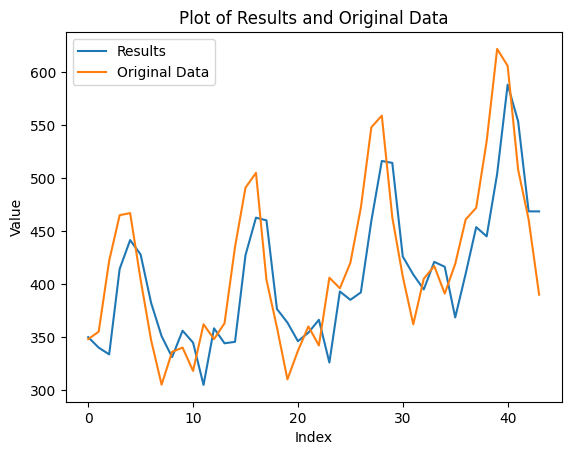

In [12]:

# since results and original_data are 3D arrays, we need to convert them to 1D for plotting
results_1d = results.flatten()
# # create an array of five zeros
# zeros = np.zeros(configs.seq_len -1 )
# print(zeros)
# # concatenate the zeros to the beginning of results_1d
# results_1d = np.concatenate((zeros, results_1d))

original_data_1d = original_data.flatten()

plt.plot(results_1d, label='Results')
plt.plot(original_data_1d[4:48], label='Original Data')
plt.title('Plot of Results and Original Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [13]:
test_data = dataset[train_size:len(dataset),:]

test_one_data = test_data[1:5]
true_result = test_data[6]
print(test_one_data, true_result)
inputs = torch.tensor(test_one_data, dtype=torch.float32)
inputs = inputs.unsqueeze(0)
print(inputs.shape)
model.eval()
with torch.no_grad():
    outputs = model(inputs)
    pred = outputs.detach().cpu().numpy()  # .squeeze()
    # preds = scaler.inverse_transform(pred.squeeze(2))
    print(pred)

[[0.4073359 ]
 [0.3803089 ]
 [0.48648646]
 [0.47104248]] [0.6138996]
torch.Size([1, 4, 1])
[[[0.45553038]]]


In [54]:
print(dataset[train_size:len(dataset),:].shape)

(49, 1)
